## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)


Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [287]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Определим функции

In [288]:
# выводит диаграмму разброса и гистограмму на одном поле
def plot_scat_hist(df, column_x, column_y, hist_bins):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax1, ax2, ax3 = ax.flatten()
    ax1.scatter(df[column_x], df[column_y])
    ax2.hist(df[column_x], bins=hist_bins)
    ax3.hist(df[column_y], bins=hist_bins)
    
    ax1.set_title(f'x = {column_x}, y = {column_y}')
    ax2.set_title(column_x)
    ax3.set_title(column_y)
    
    fig.set_size_inches(20, 7)
    return None

In [289]:
# выводит диаграмму разброса 
def plot_scat(df, column_x:str, column_y:str):
    
    plt.scatter(df[column_x], df[column_y])
    plt.ylabel(column_y)
 
    plt.scatter(df[column_x])
    
    plt.xlabel(column_x)
    
    plt.title('train')
    return None

In [290]:
# выводит гистограмму 
def plot_hist(df, column_x:str, column_y=None, hist_bins=10):
    
    if column_y:
        plt.hist(df[column_x], df[column_y], bins=hist_bins)
        plt.ylabel(column_y)
    else:
        plt.hist(df[column_x], bins=hist_bins)
    
    plt.xlabel(column_x)
    
    plt.title('train')
    return None

###  Загружаем данные из файлов

In [291]:
TEST = 'data/test.csv'
TRAIN = 'data/train.csv'

In [292]:
df_test = pd.read_csv(TEST)
df_train = pd.read_csv(TRAIN)

### Посмотрим на содержание датасета

In [293]:
df_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [294]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [295]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


##### Избавимся от числовых типов в категориальных признаках: Id и DistrictId

In [296]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)

##### Преобразуем категориальные признаки в числовые

In [297]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [298]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [299]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [300]:
df_train['Ecology_2'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2'] = df_train['Shops_2'].replace({'A':0, 'B':1})

### Обработка NaN-ов, выбросов и некорректных значений

Используя статистику, видим, что у следующих признаков максимальное значение значительно отличается от 75-го квантиля

In [301]:
square_list = ['Square', 'LifeSquare', 'KitchenSquare']

In [302]:
df_train.loc[:, square_list].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,56.315775,37.199645,6.273300
std,21.058732,86.241209,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,22.769832,1.000000
50%,52.513310,32.781260,6.000000
75%,65.900625,45.128803,9.000000
max,641.065193,7480.592129,2014.000000


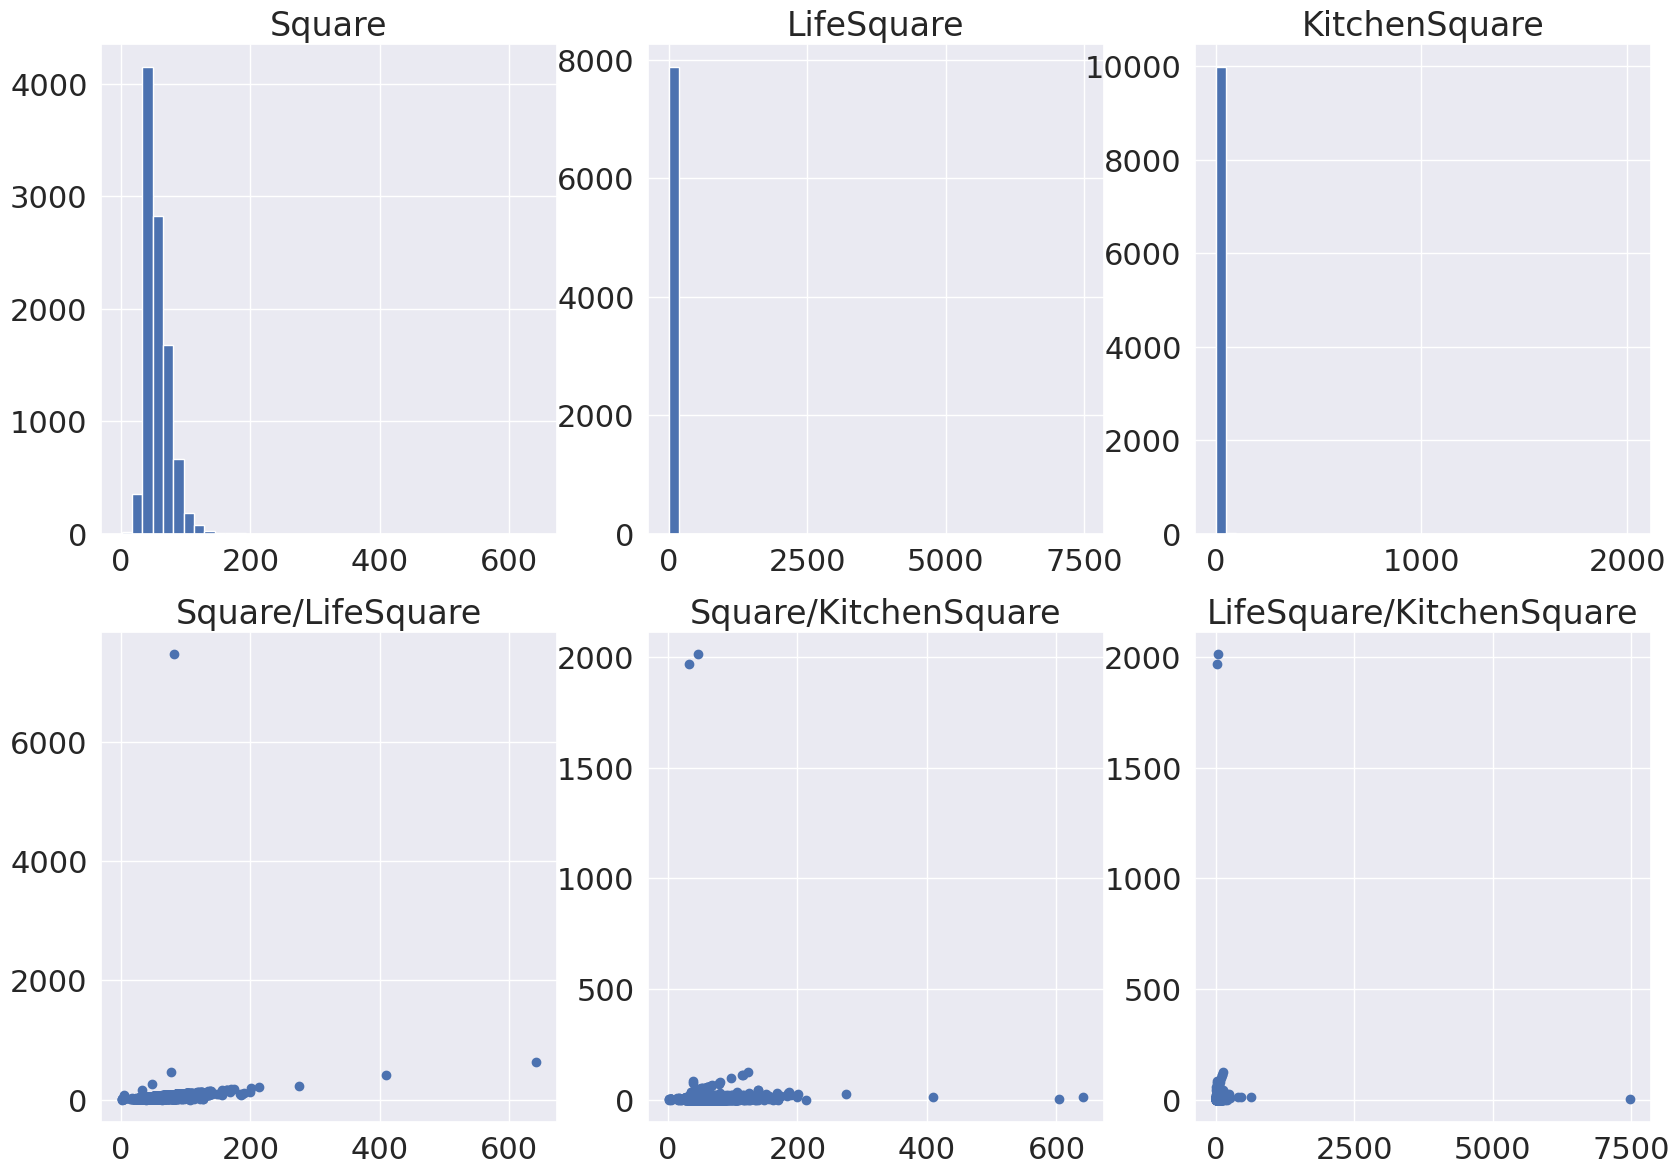

In [303]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.hist(df_train['Square'], bins=40)
ax2.hist(df_train['LifeSquare'], bins=40)
ax3.hist(df_train['KitchenSquare'], bins=40)

ax4.scatter(df_train['Square'], df_train['LifeSquare'])
ax5.scatter(df_train['Square'], df_train['KitchenSquare'])
ax6.scatter(df_train['LifeSquare'], df_train['KitchenSquare'])

ax1.set_title('Square')
ax2.set_title('LifeSquare')
ax3.set_title('KitchenSquare')
ax4.set_title('Square/LifeSquare')
ax5.set_title('Square/KitchenSquare')
ax6.set_title('LifeSquare/KitchenSquare')

fig.set_size_inches(20, 14)

##### Обрежем выбросы

In [304]:
df_train = df_train[(df_train['Square'] < 150) & (df_train['Square'] > 20)]
df_train = df_train[(df_train['LifeSquare'] < 120) & (df_train['LifeSquare'] > 10)]
df_train = df_train[(df_train['KitchenSquare'] < 25) & (df_train['KitchenSquare'] > 5)]

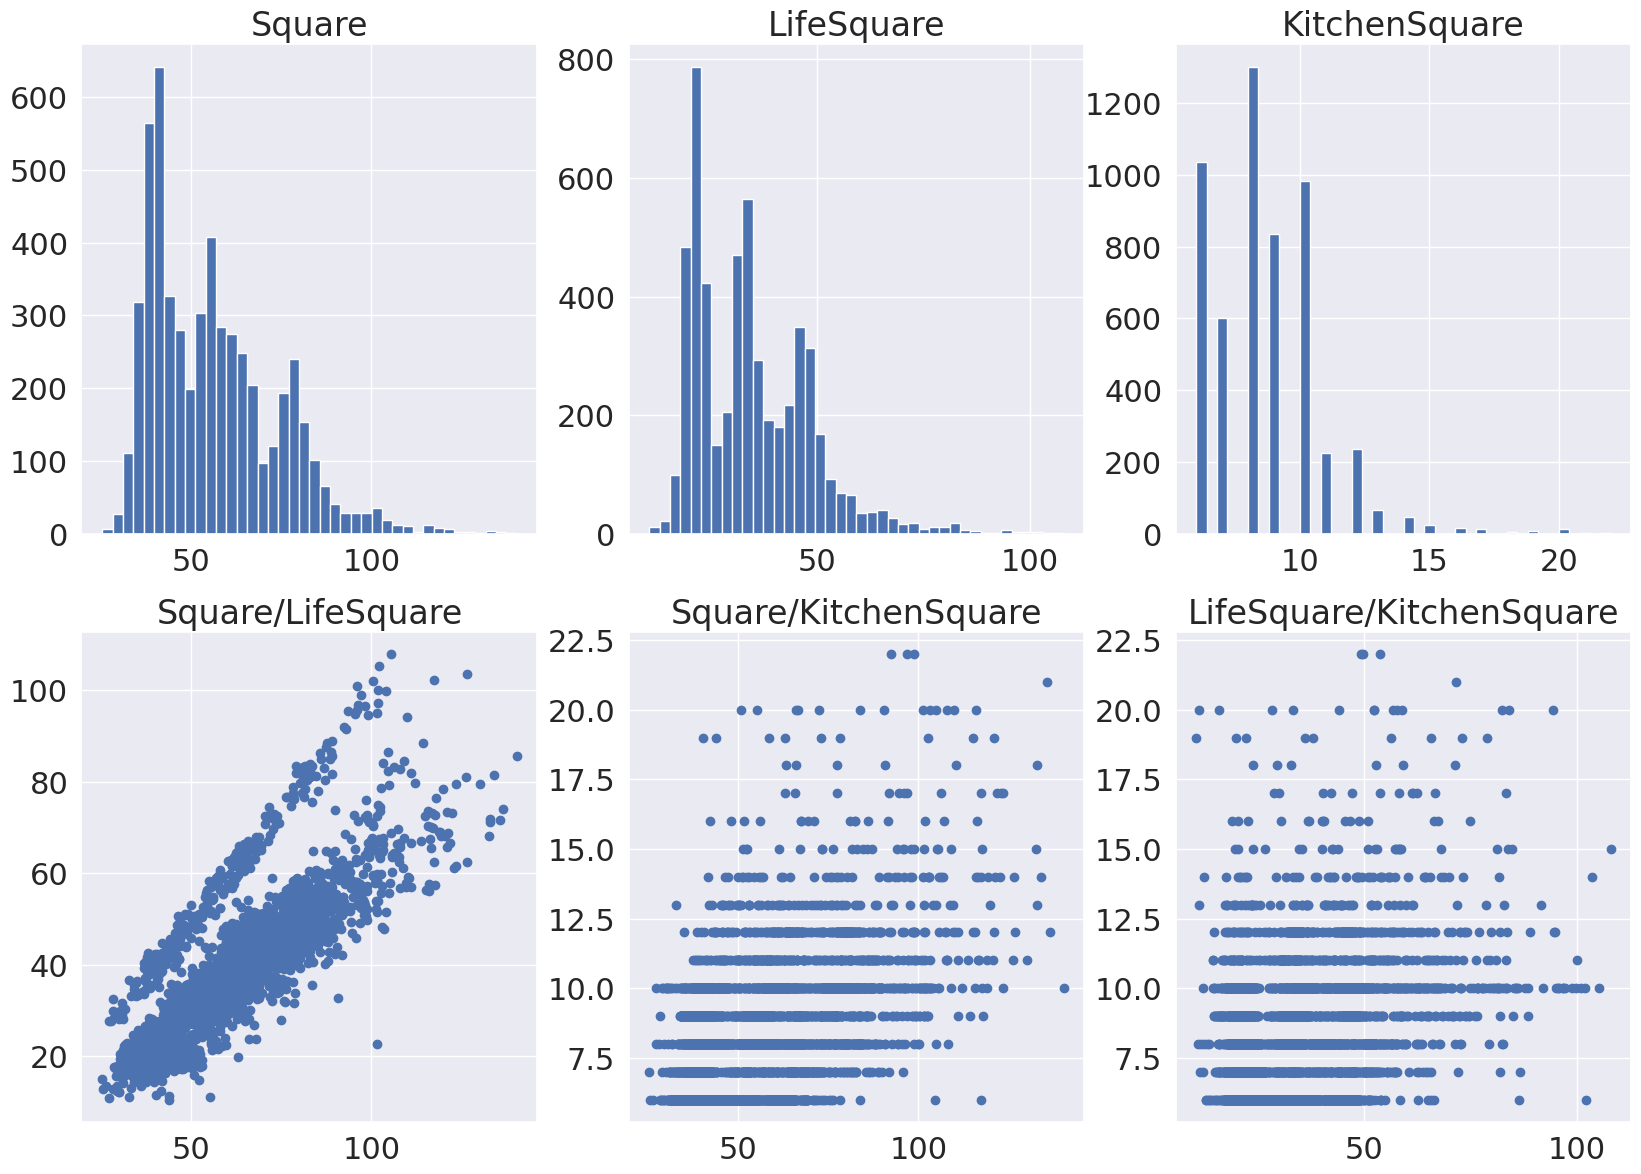

In [305]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.hist(df_train['Square'], bins=40)
ax2.hist(df_train['LifeSquare'], bins=40)
ax3.hist(df_train['KitchenSquare'], bins=40)

ax4.scatter(df_train['Square'], df_train['LifeSquare'])
ax5.scatter(df_train['Square'], df_train['KitchenSquare'])
ax6.scatter(df_train['LifeSquare'], df_train['KitchenSquare'])

ax1.set_title('Square')
ax2.set_title('LifeSquare')
ax3.set_title('KitchenSquare')
ax4.set_title('Square/LifeSquare')
ax5.set_title('Square/KitchenSquare')
ax6.set_title('LifeSquare/KitchenSquare')

fig.set_size_inches(20, 14)

##### Есть записи, в которых жилая площадь привышает общюу:

In [306]:
df_train[df_train['Square'] < df_train['LifeSquare']].count()['Id']

103

Удалим эти записи

In [307]:
df_train = df_train[df_train['Square'] > df_train['LifeSquare']]

##### Так-же есть записи, в которых этаж квартиры больше этажности самого здания:

In [308]:
df_train[df_train['Floor'] > df_train['HouseFloor']].count()['Id']

563

Удалим эти данные

In [309]:
df_train = df_train[df_train['Floor'] <= df_train['HouseFloor']]

In [310]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4748 non-null   object 
 1   DistrictId     4748 non-null   object 
 2   Rooms          4748 non-null   float64
 3   Square         4748 non-null   float64
 4   LifeSquare     4748 non-null   float64
 5   KitchenSquare  4748 non-null   float64
 6   Floor          4748 non-null   int64  
 7   HouseFloor     4748 non-null   float64
 8   HouseYear      4748 non-null   int64  
 9   Ecology_1      4748 non-null   float64
 10  Ecology_2      4748 non-null   int64  
 11  Ecology_3      4748 non-null   int64  
 12  Social_1       4748 non-null   int64  
 13  Social_2       4748 non-null   int64  
 14  Social_3       4748 non-null   int64  
 15  Healthcare_1   2728 non-null   float64
 16  Helthcare_2    4748 non-null   int64  
 17  Shops_1        4748 non-null   int64  
 18  Shops_2 

Теперь у нас в датасете остался с NaN-ами только признак Healthcare_1. Посмотрим, нужен ли этот признак.
Для этого возьмем часть датасета, в которой присутствует этот признак и цену, и создадим для этой части датасэта кореляционную матрицу

In [311]:
df_train_H1 = df_train[~df_train['Healthcare_1'].isna()]

<AxesSubplot: >

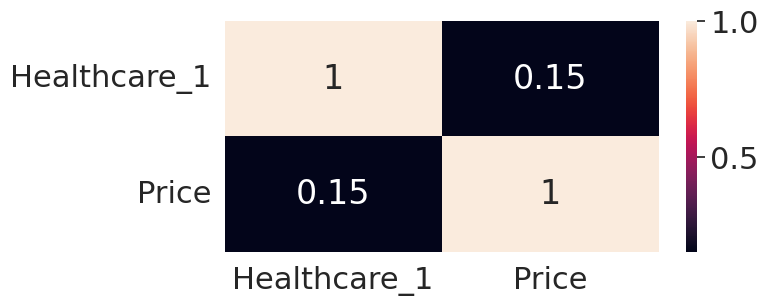

In [312]:
plt.figure(figsize=(7,3))
sns.set(font_scale=2)
sns.heatmap(df_train_H1.loc[:, ['Healthcare_1', 'Price']].corr(), annot=True)

Метрика Healthcare_1 не сильно влияет на Price, удалим эту колонку совсем.

In [313]:
df_train = df_train.drop(columns=['Healthcare_1'])

In [314]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4748 non-null   object 
 1   DistrictId     4748 non-null   object 
 2   Rooms          4748 non-null   float64
 3   Square         4748 non-null   float64
 4   LifeSquare     4748 non-null   float64
 5   KitchenSquare  4748 non-null   float64
 6   Floor          4748 non-null   int64  
 7   HouseFloor     4748 non-null   float64
 8   HouseYear      4748 non-null   int64  
 9   Ecology_1      4748 non-null   float64
 10  Ecology_2      4748 non-null   int64  
 11  Ecology_3      4748 non-null   int64  
 12  Social_1       4748 non-null   int64  
 13  Social_2       4748 non-null   int64  
 14  Social_3       4748 non-null   int64  
 15  Helthcare_2    4748 non-null   int64  
 16  Shops_1        4748 non-null   int64  
 17  Shops_2        4748 non-null   int64  
 18  Price   

##### Не корректные данные есть в поле HouseYear - отсеим все, что "из будущего"  

In [315]:
df_train[df_train['HouseYear'] > 2020].count()['Id']

1

In [316]:
df_train = df_train[df_train['HouseYear'] <= 2020]

In [317]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000
mean,1.960607,56.128824,34.108339,8.584158,7.986518,13.973246,1987.120918,0.122867,0.990520,0.963977,31.670107,6815.070150,6.364441,1.618285,4.931114,0.931746,238311.854650
std,0.890275,17.665321,13.178579,2.103773,4.705780,5.092106,18.003000,0.120412,0.096911,0.186366,16.128183,3963.795135,15.609593,1.512160,4.254406,0.252207,99072.446314
min,0.000000,25.410513,10.523868,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.231222,22.541158,7.000000,4.000000,9.000000,1974.000000,0.033494,1.000000,1.000000,22.000000,4455.500000,1.000000,0.000000,2.000000,1.000000,171298.249975
50%,2.000000,53.469433,32.475733,8.000000,7.000000,14.000000,1985.000000,0.090799,1.000000,1.000000,30.000000,5992.000000,3.000000,1.000000,4.000000,1.000000,214532.575855
75%,3.000000,66.281881,43.791022,10.000000,11.000000,17.000000,2003.000000,0.188784,1.000000,1.000000,42.000000,8429.000000,5.000000,3.000000,7.000000,1.000000,288946.032458
max,19.000000,140.242987,103.637322,22.000000,33.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,625678.644994


### Генерация новых признаков

In [318]:
# Соотношение жилой площади к общей площади квартиры
df_train['Life_Full_Square'] = df_train['LifeSquare'] / df_train['Square'] 

In [319]:
# Соотношение площади кухни к жилой площади квартиры
df_train['Kitchen_Life_Square'] = df_train['KitchenSquare'] / df_train['LifeSquare'] 

In [320]:
# Соотношение жилой площади квартиры к количеству комнат
df_train['LifeSquare_Rooms'] = df_train['LifeSquare'] / df_train['Rooms'] 

In [321]:
# Медианная цена за кв.метр по району и году постройки
sq_1 = df_train.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedianPrice_by_DctYear'})
sq_1[sq_1['HouseYear'] == 2020]

,DistrictId,HouseYear,MedianPrice_by_DctYear
345,120,2020,536020.260344
752,169,2020,295304.011974
1597,53,2020,247976.085539
1797,62,2020,138770.715048


In [322]:
df_train = df_train.merge(sq_1, on=['DistrictId', 'HouseYear'], how='left')

Попробуем ввести переменную, которая будет соберать совокупную привлекательность постройки:

In [323]:
curr_year = 2023
df_train['attractive_loc'] = (df_train['HouseYear']/curr_year) + ((df_train['Ecology_1'] + df_train['Ecology_2'] + df_train['Ecology_3'])/3 ) + ((df_train['Shops_1']/100) + df_train['Shops_2']) 

In [324]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Life_Full_Square,Kitchen_Life_Square,LifeSquare_Rooms,MedianPrice_by_DctYear,attractive_loc
count,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,...,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000
mean,1.960607,56.128824,34.108339,8.584158,7.986518,13.973246,1987.120918,0.122867,0.990520,0.963977,...,6.364441,1.618285,4.931114,0.931746,238311.854650,0.601469,0.282171,inf,238311.854650,2.655777
std,0.890275,17.665321,13.178579,2.103773,4.705780,5.092106,18.003000,0.120412,0.096911,0.186366,...,15.609593,1.512160,4.254406,0.252207,99072.446314,0.103989,0.112752,NaN,85804.311752,0.268215
min,0.000000,25.410513,10.523868,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,59174.778028,0.222840,0.058716,1.146278,64298.216337,1.440916
25%,1.000000,41.231222,22.541158,7.000000,4.000000,9.000000,1974.000000,0.033494,1.000000,1.000000,...,1.000000,0.000000,2.000000,1.000000,171298.249975,0.541269,0.202470,15.516963,181653.063756,2.685519
50%,2.000000,53.469433,32.475733,8.000000,7.000000,14.000000,1985.000000,0.090799,1.000000,1.000000,...,3.000000,1.000000,4.000000,1.000000,214532.575855,0.593368,0.261220,17.255218,218469.023207,2.711507
75%,3.000000,66.281881,43.791022,10.000000,11.000000,17.000000,2003.000000,0.188784,1.000000,1.000000,...,5.000000,3.000000,7.000000,1.000000,288946.032458,0.642925,0.347383,20.700051,270487.278622,2.770549
max,19.000000,140.242987,103.637322,22.000000,33.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,...,141.000000,6.000000,23.000000,1.000000,625678.644994,0.999949,1.805420,inf,625678.644994,2.892738


### Построим корелляционную матрицу по всем признакам

/tmp/ipykernel_4029/3890439596.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True, cmap="YlOrBr")


<AxesSubplot: >

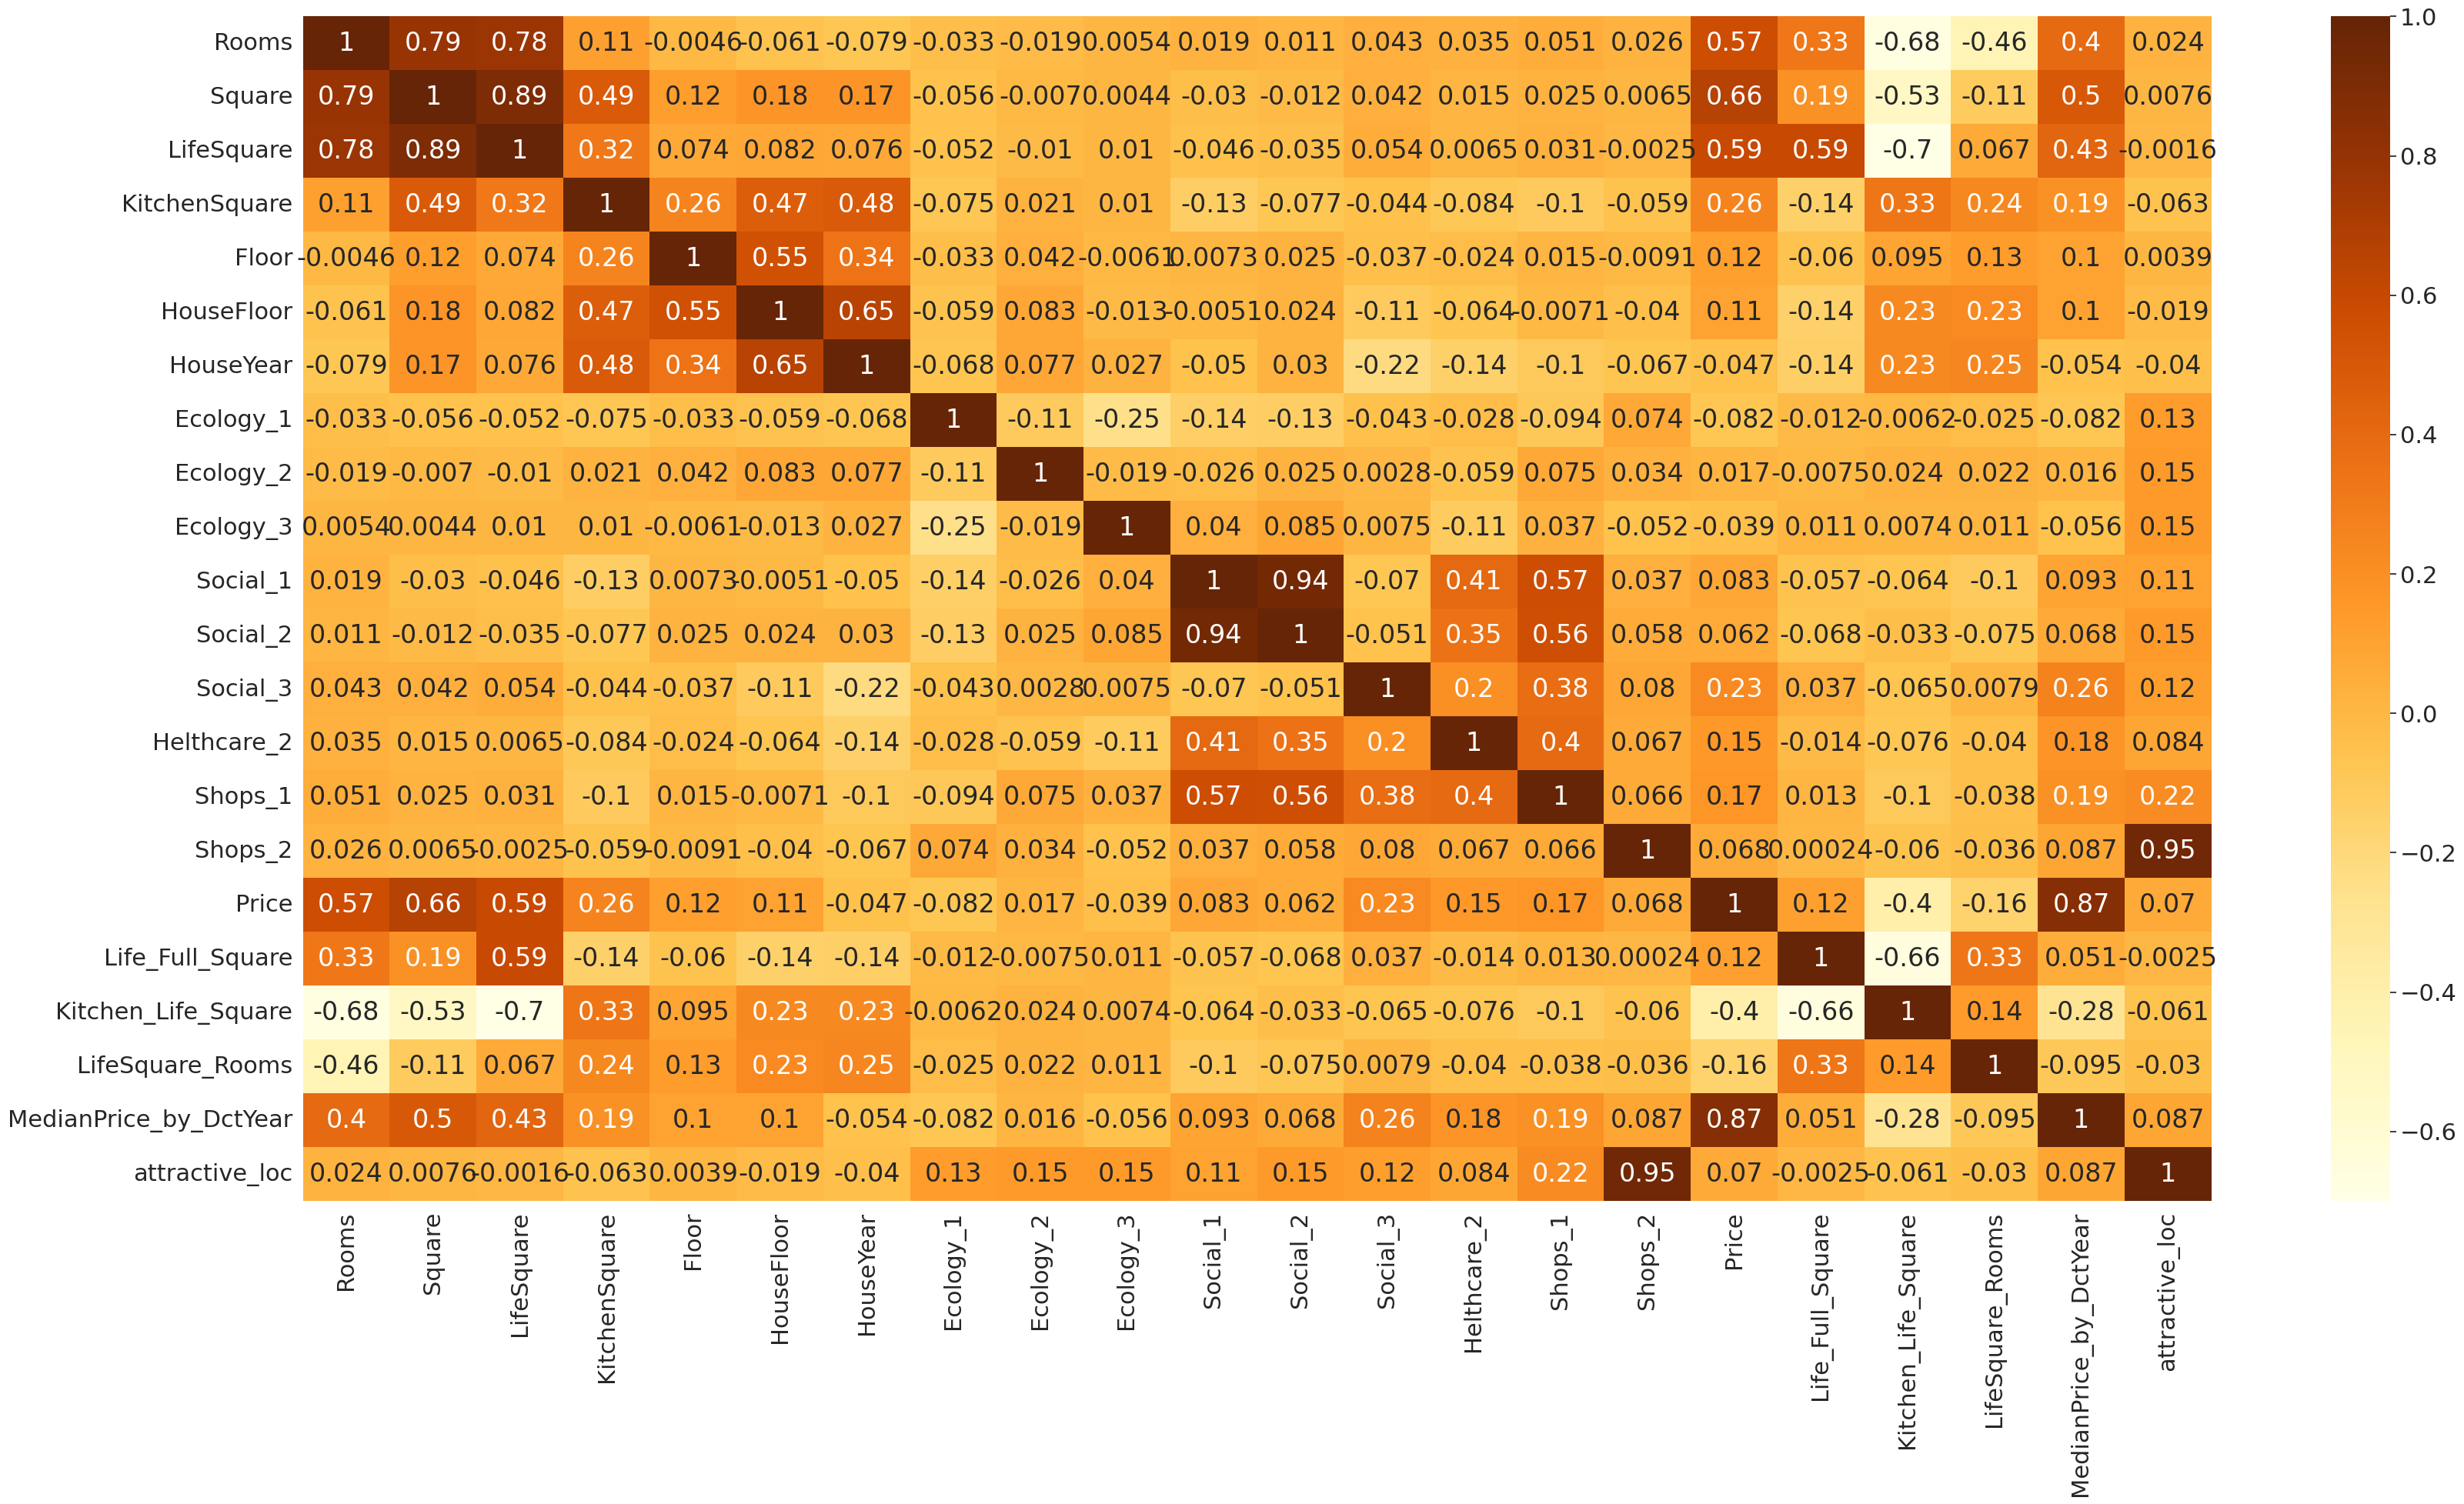

In [325]:
plt.figure(figsize=(40,20))
sns.set(font_scale=2)
sns.heatmap(df_train.corr(), annot=True, cmap="YlOrBr")

In [326]:
#  Уберем признаки:
to_drop = ['Kitchen_Life_Square', 'Shops_2', 'LifeSquare', 'Rooms', 'Social_2']
df = df_train.drop(columns=to_drop)

/tmp/ipykernel_4029/3579371694.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="YlOrBr")


<AxesSubplot: >

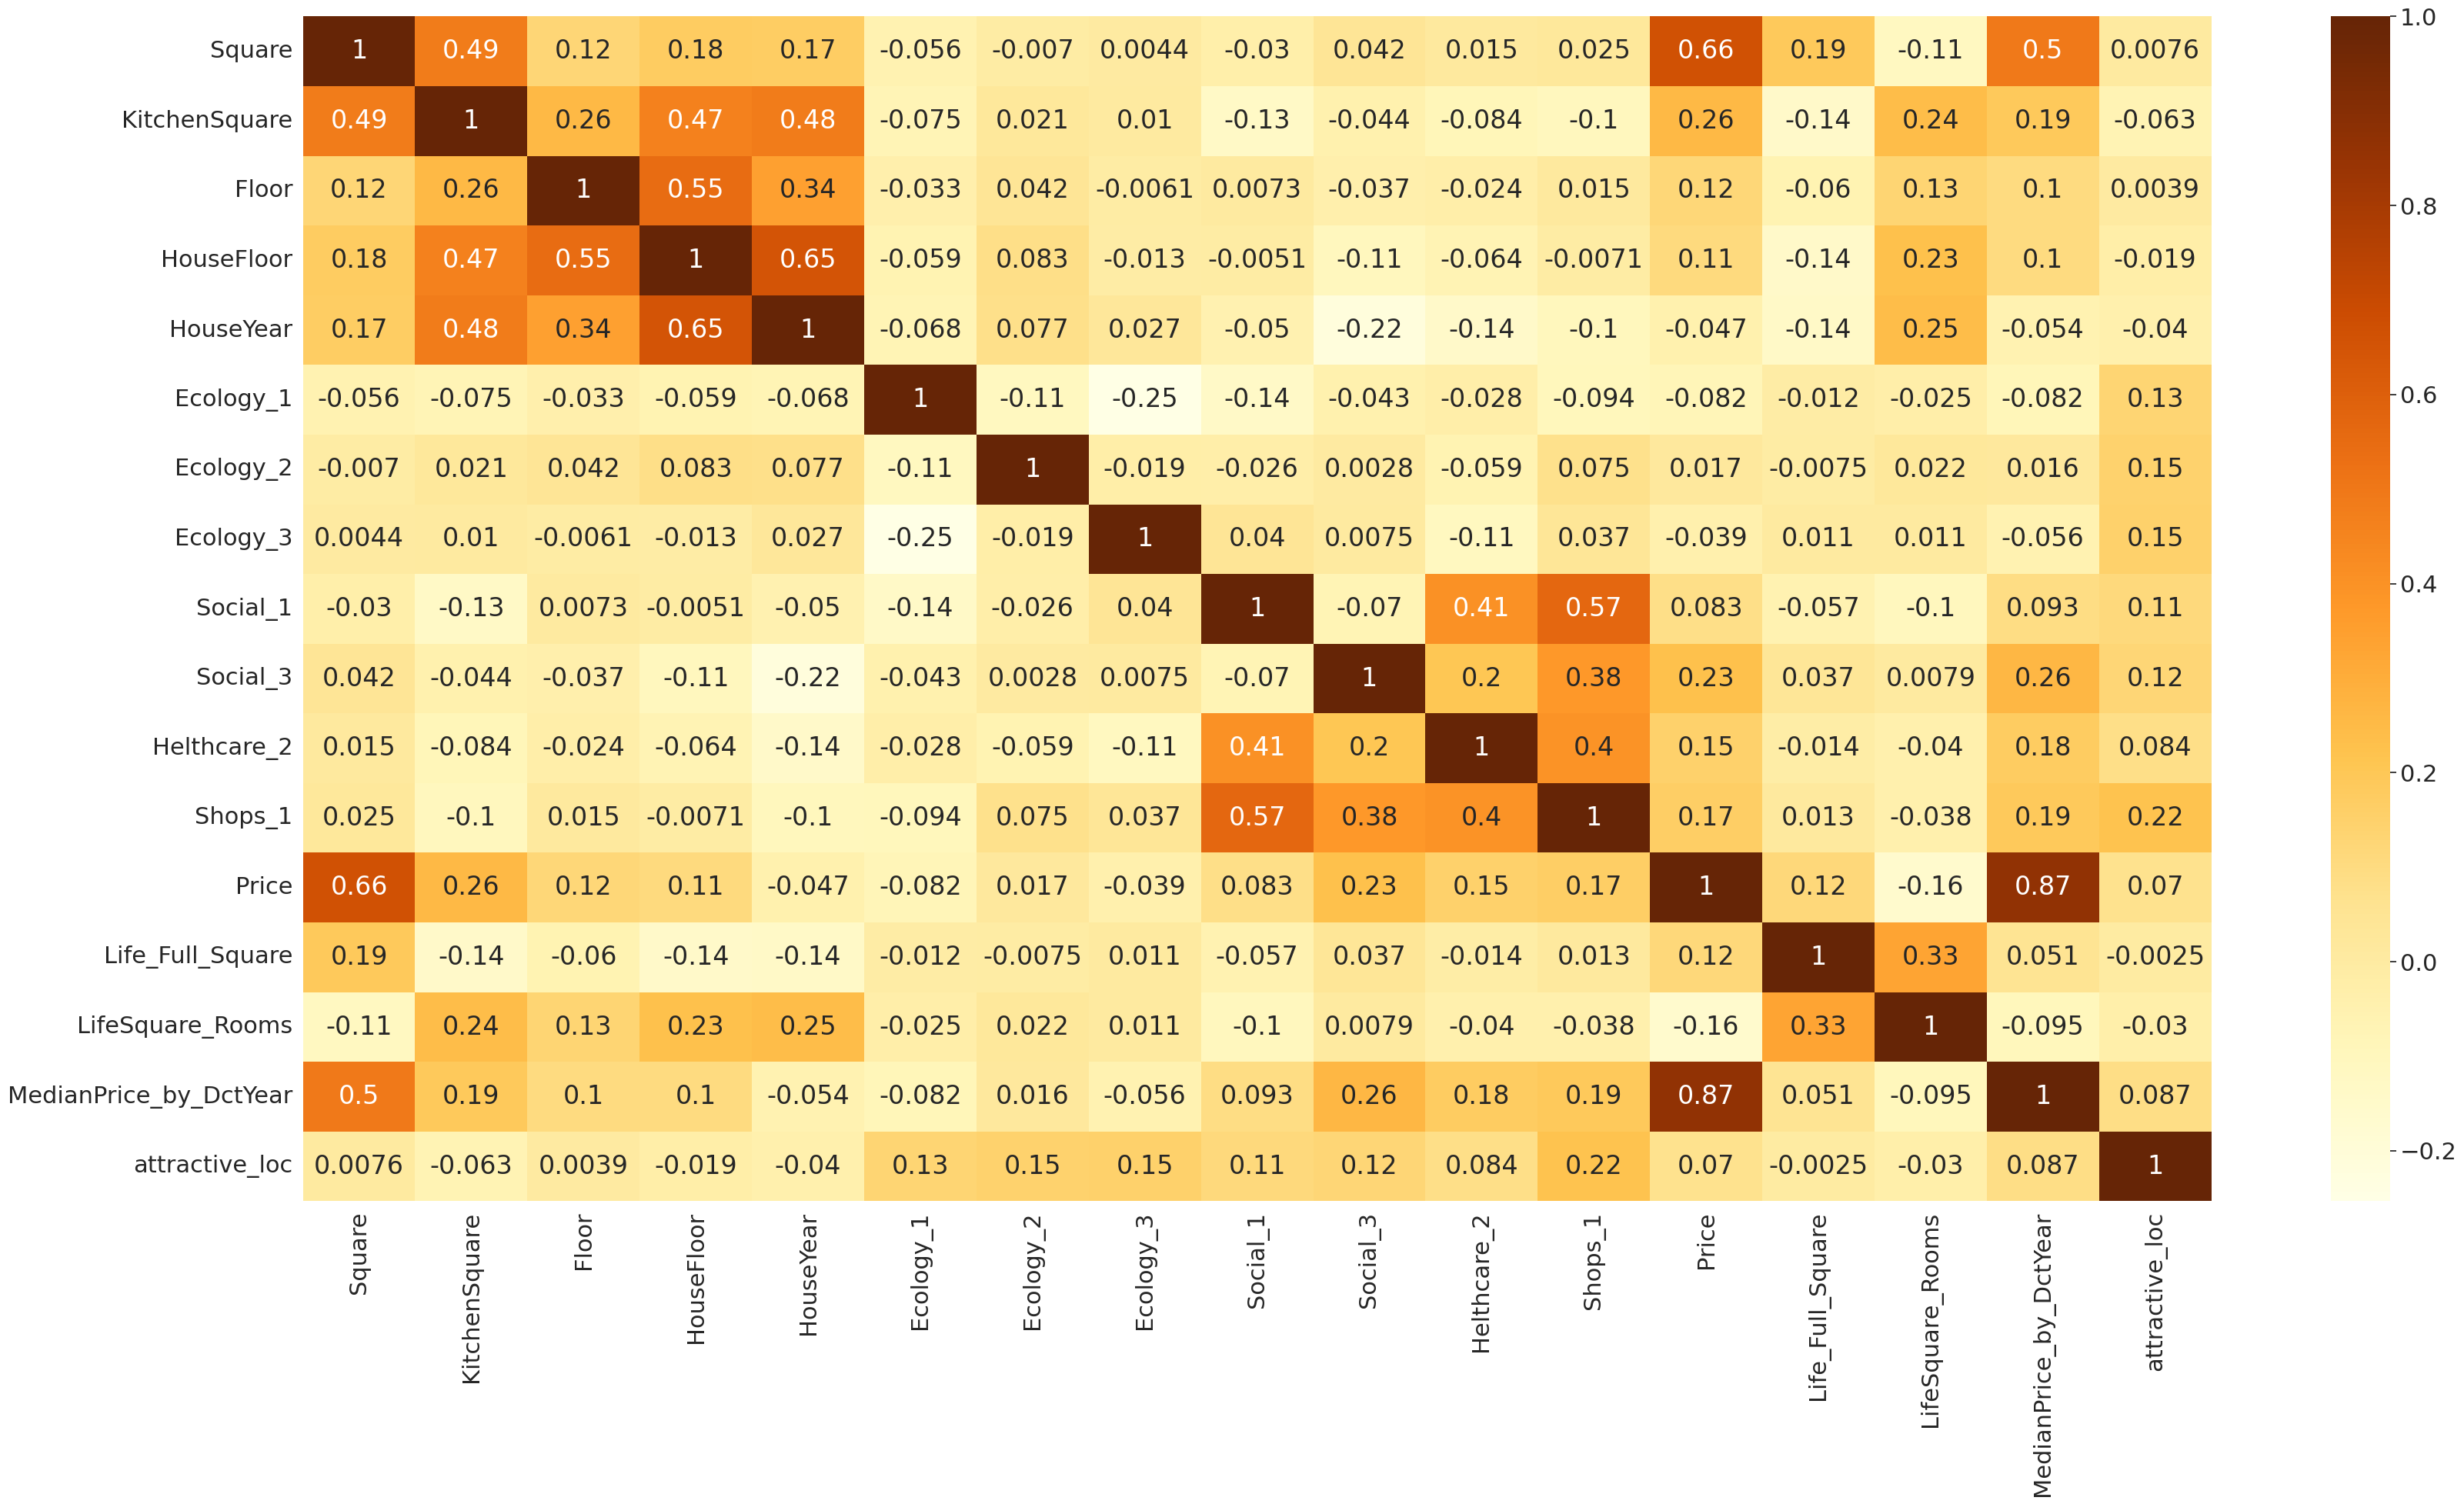

In [327]:
plt.figure(figsize=(40,20))
sns.set(font_scale=2)
sns.heatmap(df.corr(), annot=True, cmap="YlOrBr")

##### Посмотрим гистограмму разброса цен

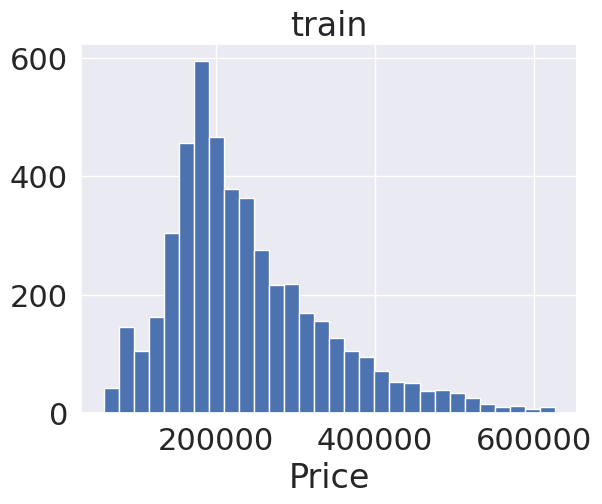

In [328]:
plot_hist(df_train, 'Price', hist_bins=30)